In [45]:
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
import seaborn as sns
from t2e_utils import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")

import os
plt.style.use('seaborn-muted')

%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py


range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2),
    'a_complete': range(2,8,1),
    'b_complete': range(2,22,2),
    'c_complete': range(2,12,2),
    'd_complete': range(2,22,2),
    'a_reduced': range(2,8,1),
    'b_reduced': range(2,22,2),
    'c_reduced': range(2,12,2),
    'd_reduced': range(2,22,2),

}

maes_path = "output_files/maes/baseline/"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
## Evaluate baseline results and save to pickle file

path_baseline_results = '../Tax_paper/code/output_files/results/'

a_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_helpdesk.csv')
b_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w.csv')
c_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
d_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_env_permit.csv')

a_complete = pd.read_csv(a_complete)
b_complete = pd.read_csv(b_complete)
c_complete = pd.read_csv(c_complete)
d_complete = pd.read_csv(d_complete)

a_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_helpdesk_reduced.csv')
b_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_reduced.csv')
c_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_no_repeat_reduced.csv')
d_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_env_permit_reduced.csv')

a_reduced = pd.read_csv(a_reduced)
b_reduced = pd.read_csv(b_reduced)
c_reduced = pd.read_csv(c_reduced)
d_reduced = pd.read_csv(d_reduced)


df_dict = {
    'a_complete': a_complete,
    'b_complete': b_complete,
    'c_complete': c_complete,
    'd_complete': d_complete,
    'a_reduced': a_reduced,
    'b_reduced': b_reduced,
    'c_reduced': c_reduced,
    'd_reduced': d_reduced
}

for dataset in df_dict.keys():
    tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
    tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
    pickle.dump(list(tmp.values()), open(maes_path + dataset +'.pkl', "wb"))

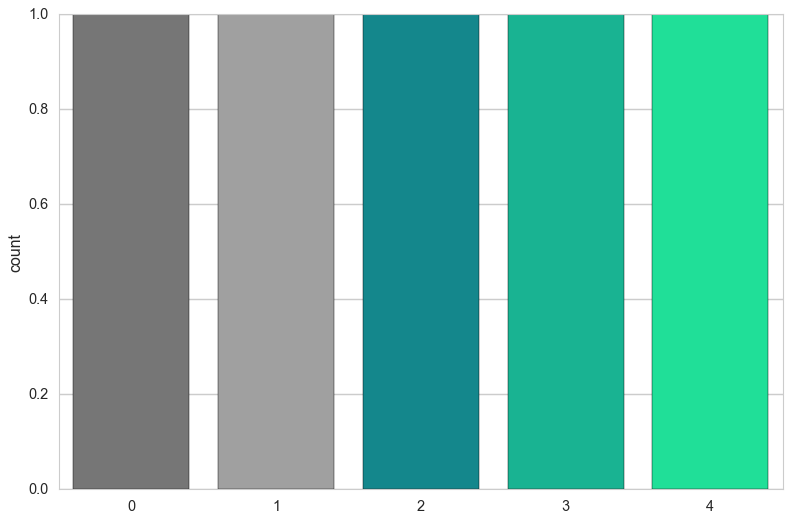

In [149]:
# colors = ['#0FC373','#FAD22D','#FF8C0A','#FF3232','#181818','#0082F0','#AF78D2','#767676', '#A0A0A0', '#E0E0E0']
colors = ['#767676', '#A0A0A0','#0099A0','#00CCA0', '#00FFA0']

def draw_palette():
    sns.countplot( x=np.arange(len(colors)), palette=colors);
    plt.show();
draw_palette()

In [29]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn',
 'seaborn-bright',
 'seaborn-colorblind',
 'seaborn-dark',
 'seaborn-dark-palette',
 'seaborn-darkgrid',
 'seaborn-deep',
 'seaborn-muted',
 'seaborn-notebook',
 'seaborn-paper',
 'seaborn-pastel',
 'seaborn-poster',
 'seaborn-talk',
 'seaborn-ticks',
 'seaborn-white',
 'seaborn-whitegrid',
 'tableau-colorblind10']

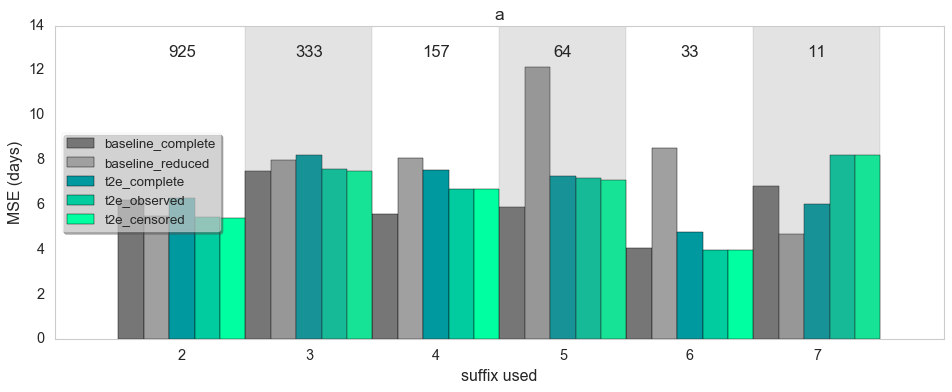

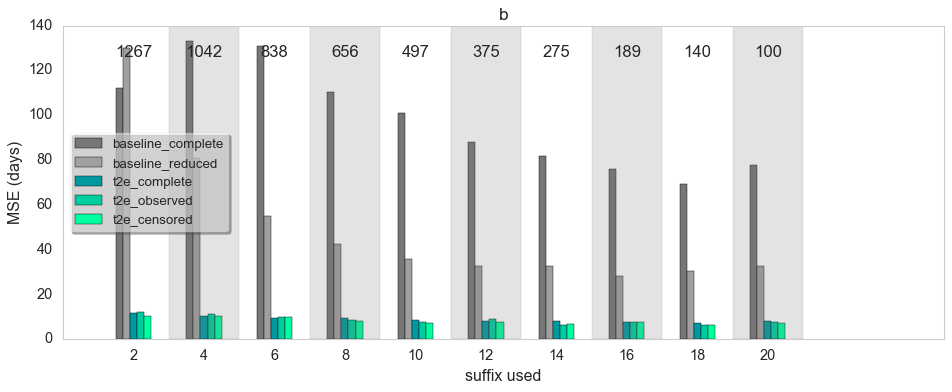

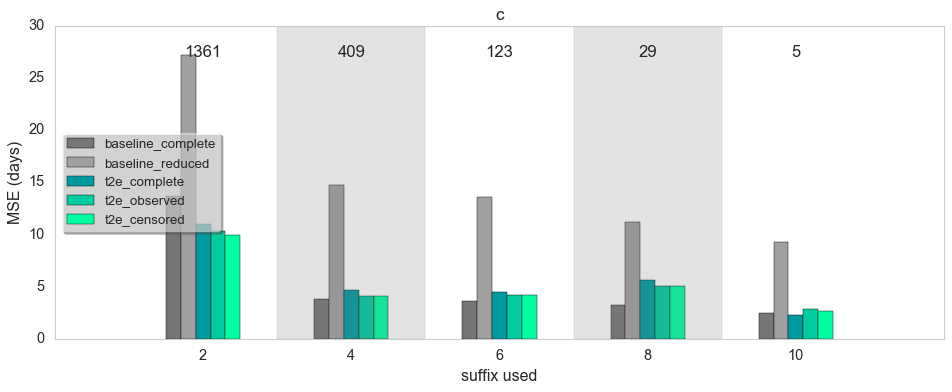

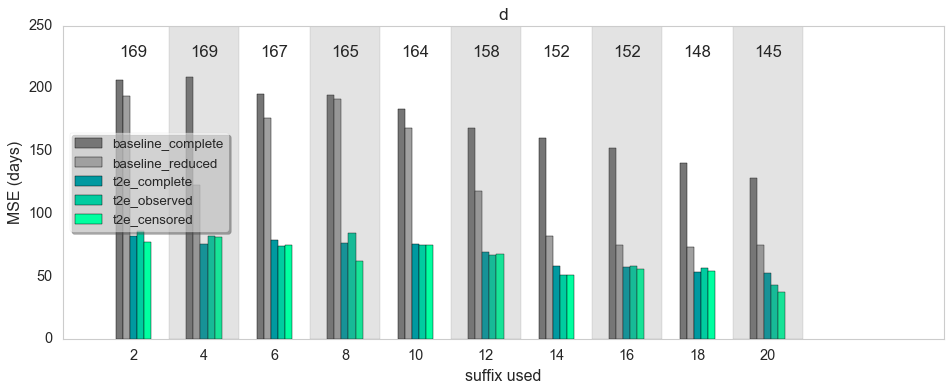

In [150]:
for dataset in ['a','b','c','d']:
    plt.style.use('seaborn-deep')
    ## Load baseline:
    path = 'output_files/maes/baseline/'
    baseline_reduced  = pickle.load(open(path + dataset +'_reduced.pkl', 'rb'))
    baseline_complete = pickle.load(open(path + dataset +'_complete.pkl', 'rb'))

    ## Load grid search results single layer
    path = 'output_files/maes/double_layer/'
    grid_results_com_dl = list(np.squeeze(pickle.load(open(path + 't2e_'+dataset+'_complete.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
    grid_results_obs_dl = list(np.squeeze(pickle.load(open(path + 't2e_'+dataset+'_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
    grid_results_cen_dl = list(np.squeeze(pickle.load(open(path + 't2e_'+dataset+'_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

    ## Cases
    cases = [
        baseline_complete,
        baseline_reduced,
        grid_results_com_dl,
        grid_results_obs_dl,
        grid_results_cen_dl,
    ]

    ## Plotting
    labels= [
        "baseline_complete", 
        "baseline_reduced",
        "t2e_complete",
        "t2e_observed",
        "t2e_censored"
    ]
    steps = [-0.4,-0.2, 0, 0.2,0.4]

    fig, ax = plt.subplots(1, 1, figsize=(12,5))
    X = np.array(range_dict[dataset])
    for j,case in enumerate(cases):
        plt.bar(
            x      = X + steps[j], 
            height = case,
            width  = 0.2,
            label = labels[j],
            color = colors[j]
        );

    text_counts = pickle.load(open(path + 't2e_'+dataset+'_censored.pkl', 'rb'))\
                                .sort_values(['suffix','MAE'])\
                                .drop_duplicates(subset=['suffix'], keep='first')\
                                .reset_index(drop=True)\
                                ["test_size"]\
                                .values
    for i, span in enumerate(X):
        if dataset == 'a':
            plt.axvspan(span-0.5, span+0.5, facecolor='#767676', alpha=(i%2)*0.2)
        else:
            plt.axvspan(span-1, span+1, facecolor='#767676', alpha=(i%2)*0.2)
        ax.text(span,ax.get_ylim()[1]-10*ax.get_ylim()[1]/100,'{:1.0f}'.format(text_counts[i]),ha="center", fontsize=15);

    plt.xticks(range_dict[dataset])
    plt.legend(loc='center left',frameon = True, fancybox =True, shadow = True, framealpha=0.5,fontsize=12);
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
    plt.tight_layout()
    plt.grid()
    plt.show()

In [80]:
dataset = 'a'
pickle.load(open(path + 't2e_'+dataset+'_censored.pkl', 'rb'))\
    .sort_values(['suffix','MAE'])\
    .drop_duplicates(subset=['suffix'], keep='first')\
    .reset_index(drop=True)\
    ["test_size"]\
    .values

array([925, 333, 157, 64, 33, 11], dtype=object)

In [100]:
pickle.load(open(path + 't2e_'+'a'+'_censored.pkl', 'rb'))

,suffix,Layer_Size,MAE,unique_pred,train_size,val_size,test_size
0,2,2,5.446079,2,1839,862,925
1,2,4,5.528569,17,1839,862,925
2,2,8,5.430026,8,1839,862,925
3,2,32,5.450019,1,1839,862,925
4,3,2,7.734297,23,717,310,333
5,3,4,7.688138,60,717,310,333
6,3,8,7.519308,57,717,310,333
7,3,32,7.784205,20,717,310,333
8,4,2,6.707376,3,324,146,157
9,4,4,6.735291,1,324,146,157


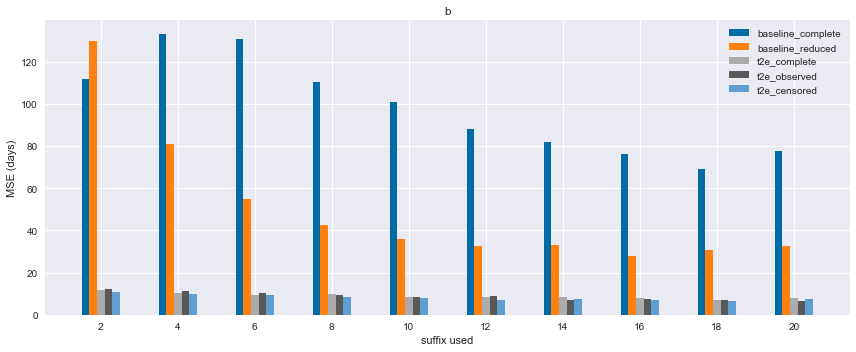

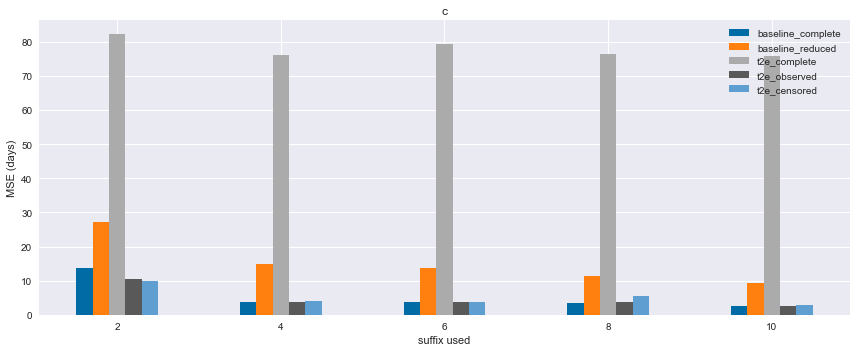

In [67]:
for dataset in ['b','c']:
    ## Load baseline:
    path = 'output_files/maes/baseline/'
    baseline_reduced  = pickle.load(open(path + dataset +'_reduced.pkl', 'rb'))
    baseline_complete = pickle.load(open(path + dataset +'_complete.pkl', 'rb'))
    
    ## Load grid search results single layer
    path = 'output_files/maes/double_layer/'
    grid_results_com_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_'+dataset+'_complete.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
    grid_results_obs_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_'+dataset+'_observed.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))
    grid_results_cen_dl = list(np.squeeze(pickle.load(open(path + 'grid_results_'+dataset+'_censored.pkl', 'rb')).groupby(["suffix"]).agg({"MAE":"min"}).values))

    ## Cases
    cases = [
        baseline_complete,
        baseline_reduced,
        grid_results_com_dl,
        grid_results_obs_dl,
        grid_results_cen_dl,
    ]
    
    ## Plotting
    labels= [
        "baseline_complete", 
        "baseline_reduced",
        "t2e_complete",
        "t2e_observed",
        "t2e_censored"
    ]
    steps = [-0.4,-0.2, 0, 0.2,0.4]
    plt.style.use('tableau-colorblind10')
    fig, ax = plt.subplots(1, 1, figsize=(12,5))
    X = np.array(range_dict[dataset])
    for j,case in enumerate(cases):
        plt.bar(x      = X + steps[j], 
                height = case,
                width  = 0.2,
                label = labels[j]);

    
    plt.xticks(range_dict[dataset])
    plt.legend();
    plt.xlabel("suffix used")
    plt.ylabel("MSE (days)")
    plt.title(dataset)
    plt.tight_layout()
    plt.grid()
    plt.show()